In [1]:
# import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# import tkinter as tk
# from tkinter import messagebox
# import open3d as o3d
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


Bad key text.latex.unicode in file /home/xi/miniconda3/envs/salsanext2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/xi/miniconda3/envs/salsanext2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/xi/miniconda3/envs/salsanext2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an

In [2]:
# Convert the coordinate system to the camera view
def look_at(camera_position, target, up):
    forward = np.float_(target - camera_position)
    forward /= np.linalg.norm(forward)

    right = np.cross(up, forward)
    right /= np.linalg.norm(right)

    up = np.cross(forward, right)

    rotation_matrix = np.array([
        [right[0], up[0], forward[0], 0],
        [right[1], up[1], forward[1], 0],
        [right[2], up[2], forward[2], 0],
        [0, 0, 0, 1]
    ])

    translation_matrix = np.array([
        [1, 0, 0, -camera_position[0]],
        [0, 1, 0, -camera_position[1]],
        [0, 0, 1, -camera_position[2]],
        [0, 0, 0, 1]
    ])

    view_matrix = rotation_matrix @ translation_matrix
    return view_matrix

In [3]:
# Perspective Projection
def perspective_projection(fov, aspect_ratio, near, far):
    f = 1 / np.tan(fov / 2)
    projection_matrix = np.array([
        [f / aspect_ratio, 0, 0, 0],
        [0, f, 0, 0],
        [0, 0, (far + near) / (near - far), (2 * far * near) / (near - far)],
        [0, 0, -1, 0]
    ])
    return projection_matrix

In [4]:
# Get the view
def project_to_screen(ndc_coords, width, height):
    x_ndc, y_ndc = ndc_coords[:, 0], ndc_coords[:, 1]
    x_screen = (x_ndc + 1) * 0.5 * width
    y_screen = (1 - y_ndc) * 0.5 * height
    ndc_coords[:, 0] = x_screen
    ndc_coords[:, 1] = y_screen
    return ndc_coords

def vis(points, color):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(color/255)
    pcd.estimate_normals()
    o3d.visualization.draw_geometries([pcd], window_name="mesh pcd")

In [5]:
def project_to_screen(ndc_coords, width, height):
    x_ndc, y_ndc = ndc_coords[:, 0], ndc_coords[:, 1]
    x_screen = (x_ndc + 1) * 0.5 * width
    y_screen = (y_ndc + 1) * 0.5 * height
    ndc_coords[:, 0] = x_screen
    ndc_coords[:, 1] = y_screen
    return ndc_coords

In [5]:
def transform_point(point, model_matrix, view_matrix, projection_matrix):
    
    world_coords = np.dot(model_matrix, point[0:4, :])
    camera_coords = np.dot(view_matrix, world_coords)
    clip_coords = np.dot(projection_matrix, camera_coords)
    #ndc_coords = clip_coords[:3, :] / clip_coords[3, :]  # Perspective division
    ndc_coords = np.vstack(((clip_coords[:3, :] / clip_coords[3, :]), point[4, :], point[5, :], point[6, :], point[7, :]))
    print(0 in clip_coords[3, :])
    return np.transpose(ndc_coords)

In [22]:
width, height = 512, 512
fov = np.pi / 1.8  # 90 degrees
near, far = 0.1, 1000
aspect_ratio = width / height
# points_3d = np.loadtxt("/home/xi/repo/Stanford3dDataset_v1.2_Aligned_Version/Area_2/storage_7/room_data/storage_7.txt")
# label = np.loadtxt("/home/xi/repo/Stanford3dDataset_v1.2_Aligned_Version/Area_2/storage_7/room_data/storage_7.label")
points_3d = np.loadtxt("/home/xi/repo/Stanford3dDataset_v1.2_Aligned_Version/Area_3/lounge_1/room_data/lounge_1.txt")
label = np.loadtxt("/home/xi/repo/Stanford3dDataset_v1.2_Aligned_Version/Area_3/lounge_1/room_data/lounge_1.label")
X = np.max(points_3d[:,1]) - np.min(points_3d[:,1])
Y = np.max(points_3d[:,2]) - np.min(points_3d[:,2])
Z = np.max(points_3d[:,0]) - np.min(points_3d[:,0])
target_type = "forward"
camera_position = np.array([np.mean(points_3d[:,1]), np.min(points_3d[:,2])+Y/1.5, np.mean(points_3d[:,0])])
if (target_type == "left"):
    target = np.array([np.min(points_3d[:,1]), np.mean(points_3d[:,2]), np.mean(points_3d[:,0])])
elif (target_type == "right"):
    target = np.array(
        [np.max(points_3d[:, 1]), np.mean(points_3d[:, 2]), np.mean(points_3d[:, 0])])
elif (target_type == "forward"):
#     target = np.array(
#         [np.mean(points_3d[:, 1]), np.mean(points_3d[:, 2]), np.min(points_3d[:, 0])])
      target = camera_position + (0, 0.1, 0)
else:
    target = np.array(
        [np.mean(points_3d[:, 1]), np.mean(points_3d[:, 2]), np.max(points_3d[:, 0])])

up = np.array([0, 1, 1])

# Define model matrix (identity for simplicity)
model_matrix = np.identity(4)

# Compute view and projection matrices
view_matrix = look_at(camera_position, target, up)
projection_matrix = perspective_projection(fov, aspect_ratio, near, far)
# Define a 3D point in homogeneous coordinates
points = np.hstack((points_3d[:, 1].reshape(-1, 1), points_3d[:, 2].reshape(-1, 1), points_3d[:, 0].reshape(-1, 1),
                    np.ones((points_3d.shape[0], 1)), points_3d[:, 3:], label.reshape(-1, 1)))  # (x, y, z, w)

# filter out the 3d points behind the camera and looking direction
forward = np.float_(target - camera_position)
forward /= np.linalg.norm(forward)
dot_products = np.dot((points[:,0:3]-camera_position), forward)
mask = dot_products > 0
valid_points = points[mask]

# valid_points = points
# Transform the point through the whole pipeline
new_coords = transform_point(np.transpose(valid_points), model_matrix, view_matrix, projection_matrix)

# Project to screen coordinates
screen_coords = project_to_screen(np.array(new_coords), width, height)

x_coords = screen_coords[:, 0].astype(np.int32)

y_coords = screen_coords[:, 1].astype(np.int32)

colors = screen_coords[:, 3:6].astype(np.uint8)  # Assuming RGB values in uint8 format

labels = screen_coords[:, 6:].astype(np.uint8)  # Assuming RGB values in uint8 format

# Calculate the actual dimensions of the image
img_width = min(np.max(x_coords) + 1, width)
img_height = min(np.max(y_coords) + 1, height)

# Create a blank image with specified dimensions
# image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
proj_l = np.zeros((img_height, img_width), dtype=np.uint8)
# Assign colors to corresponding coordinates within the limits
valid_indices = (x_coords < img_width) & (y_coords < img_height) & (0 <= x_coords) & (0 <= y_coords)
image[y_coords[valid_indices], x_coords[valid_indices]] = colors[valid_indices]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

proj_l[y_coords[valid_indices], x_coords[valid_indices]] = labels[valid_indices].reshape(-1)

False


In [133]:
image_rgb.shape

(512, 512, 3)

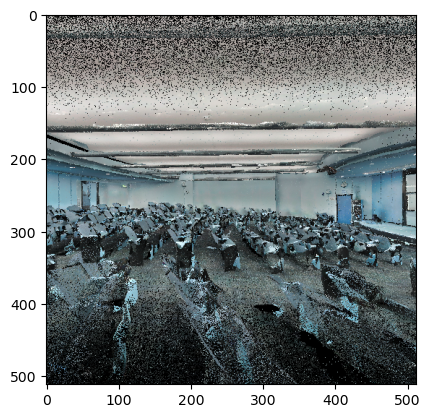

In [23]:
plt.imshow(image_rgb)

In [90]:
width, height = 512, 512
fov = np.pi   # 60 degrees
near, far = 0.1, 1000
aspect_ratio = width / height
points_3d = np.loadtxt("/home/xi/repo/Stanford3dDataset_v1.2_Aligned_Version/Area_2/auditorium_2/room_data/auditorium_2.txt")
label = np.loadtxt("/home/xi/repo/Stanford3dDataset_v1.2_Aligned_Version/Area_2/auditorium_2/room_data/auditorium_2.label")
X = np.max(points_3d[:,1]) - np.min(points_3d[:,1])
Y = np.max(points_3d[:,2]) - np.min(points_3d[:,2])
Z = np.max(points_3d[:,0]) - np.min(points_3d[:,0])
view = "tp"
target = np.array([np.mean(points_3d[:,1])-X/10, np.mean(points_3d[:,2]), np.mean(points_3d[:,0])])
if (view == "side_left"):
    camera_position = np.array([np.min(points_3d[:,1]), np.mean(points_3d[:,2]), np.mean(points_3d[:,0])])
elif (view == "side_right"):
    camera_position = np.array(
        [np.max(points_3d[:, 1]), np.mean(points_3d[:, 2]), np.mean(points_3d[:, 0])])
elif (view == "side_front"):
    camera_position = np.array(
        [np.mean(points_3d[:, 1]), np.mean(points_3d[:, 2]), np.min(points_3d[:, 0])])
elif (view == "side_back"):
    camera_position = np.array(
        [np.mean(points_3d[:, 1]), np.mean(points_3d[:, 2]), np.max(points_3d[:, 0])])
elif (view == "top"):
    camera_position = np.array(
        [np.mean(points_3d[:, 1]), np.max(points_3d[:, 2]), np.mean(points_3d[:, 0])])
else:
    camera_position = np.array(
        [np.mean(points_3d[:, 1]), np.min(points_3d[:, 2]), np.mean(points_3d[:, 0])])

up = np.array([1, 0, 1])

# Define model matrix (identity for simplicity)
model_matrix = np.identity(4)

# Compute view and projection matrices
view_matrix = look_at(camera_position, target, up)
projection_matrix = perspective_projection(fov, aspect_ratio, near, far)
# Define a 3D point in homogeneous coordinates
points = np.hstack((points_3d[:, 1].reshape(-1, 1), points_3d[:, 2].reshape(-1, 1), points_3d[:, 0].reshape(-1, 1),
                    np.ones((points_3d.shape[0], 1)), points_3d[:, 3:], label.reshape(-1, 1)))  # (x, y, z, w)

# filter out the 3d points behind the camera and looking direction
forward = np.float_(target - camera_position)
forward /= np.linalg.norm(forward)
dot_products = np.dot((points[:, 0:3] - camera_position), forward)
mask = dot_products > 0
valid_points = points[mask]

# valid_points = points
# Transform the point through the whole pipeline
new_coords = transform_point(np.transpose(valid_points), model_matrix, view_matrix, projection_matrix)

# Project to screen coordinates
screen_coords = project_to_screen(np.array(new_coords), width, height)

x_coords = screen_coords[:, 0].astype(np.int32)

y_coords = screen_coords[:, 1].astype(np.int32)

colors = screen_coords[:, 3:6].astype(np.uint8)  # Assuming RGB values in uint8 format

labels = screen_coords[:, 6:].astype(np.uint8)  # Assuming RGB values in uint8 format

# Calculate the actual dimensions of the image
# img_width = min(np.max(x_coords) + 1, width)
# img_height = min(np.max(y_coords) + 1, height)
img_width = width
img_height = height
# Create a blank image with specified dimensions
image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
proj_l = np.zeros((img_height, img_width), dtype=np.uint8)
# Assign colors to corresponding coordinates within the limits
valid_indices = (x_coords < img_width) & (y_coords < img_height) & (0 <= x_coords) & (0 <= y_coords)
image[y_coords[valid_indices], x_coords[valid_indices]] = colors[valid_indices]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

proj_l[y_coords[valid_indices], x_coords[valid_indices]] = labels[valid_indices].reshape(-1)

False


In [76]:
image.shape

(512, 512, 3)

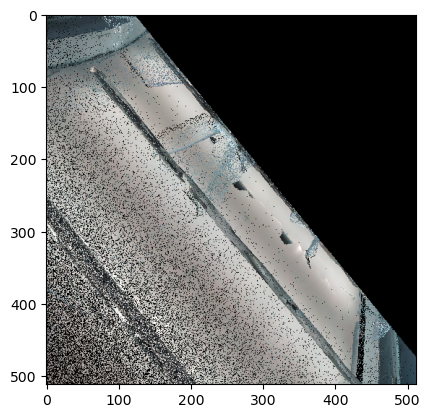

In [91]:
plt.imshow(image_rgb.reshape(512,512,3))

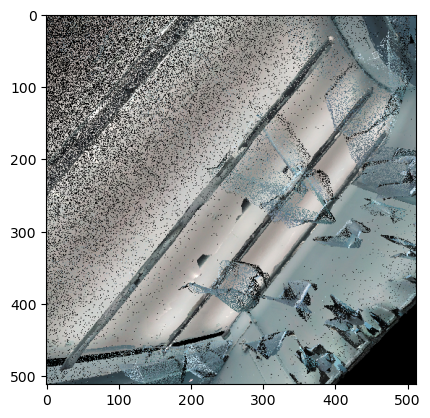

In [89]:
plt.imshow(image_rgb)

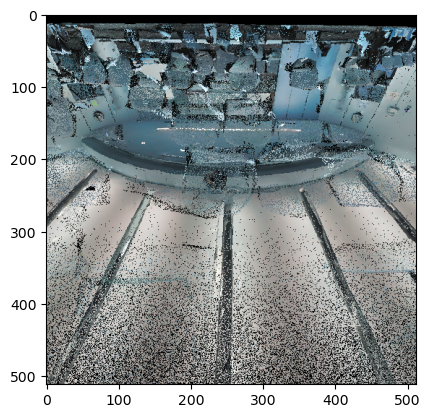

In [77]:
plt.imshow(image_rgb.reshape(512,512,3))

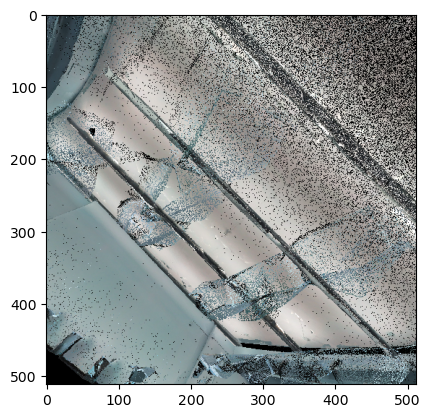

In [54]:
plt.imshow(image_rgb.reshape(512,512,3))

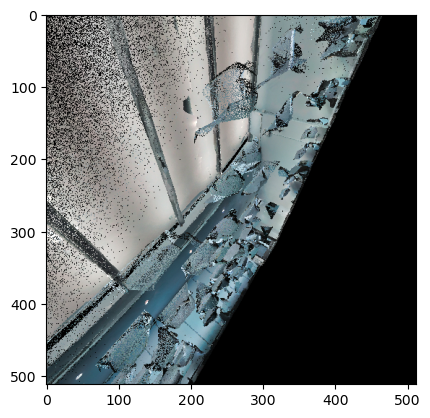

In [87]:
plt.imshow(image_rgb.reshape(512,512,3))

In [10]:
# Pre-define the view params (location, view angle... ,etc.)
width, height = 224, 224
fov = np.pi / 3.0  # 60 degrees
near, far = 0.1, 1000
aspect_ratio = width / height

points_3d = np.loadtxt("/home/xi/repo/3sdis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/conferenceRoom_2/room_data/conferenceRoom_2.txt")
label = np.loadtxt("/home/xi/repo/3sdis/Stanford3dDataset_v1.2_Aligned_Version/Area_4/conferenceRoom_2/room_data/conferenceRoom_2.label")

# Room Dimension
X = np.max(points_3d[:,1]) - np.min(points_3d[:,1])
Y = np.max(points_3d[:,2]) - np.min(points_3d[:,2])
Z = np.max(points_3d[:,0]) - np.min(points_3d[:,0])

camera_z = np.mean(points_3d[:,0])
camera_position = np.array([np.mean(points_3d[:,1]), np.mean(points_3d[:,2]), np.mean(points_3d[:,0])])
target = np.array([np.mean(points_3d[:,1])+X/10, np.mean(points_3d[:,2]), np.mean(points_3d[:,0])+Z/2])
up = np.array([0, 1, 0])

# Define model matrix (identity for simplicity)

model_matrix = np.identity(4)

# Compute view and projection matrices
view_matrix = look_at(camera_position, target, up)
projection_matrix = perspective_projection(fov, aspect_ratio, near, far)

In [4]:
labelxxx = np.loadtxt("/home/xi/repo/3sdis/whatever.txt")
vis(labelxxx[:, 0:3], labelxxx[:, 3:6])

In [50]:
vis(np.array(points_3d)[:,0:3], np.array(points_3d)[:,3:6])

In [9]:
import open3d as o3d

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [88]:
x = np.hstack((valid_points[:,2].reshape(-1, 1), valid_points[:,0].reshape(-1, 1), valid_points[:,1].reshape(-1, 1)))

In [62]:
valid_points.shape

(409521, 8)

In [7]:
vis(x, valid_points[:,4:7])

NameError: name 'x' is not defined

In [26]:
import open3d as o3d

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [26]:
np.mean(points_3d[:,2])

1.3610675340360585

In [30]:
np.mean(points[:, 1])

1.3610675340360585

In [23]:
plt.imshow(image_rgb)
plt.axis('off')
plt.close()

1.3610675340360585

In [11]:
# Define a 3D point in homogeneous coordinates
points = np.hstack((points_3d[:,1].reshape(-1, 1), points_3d[:,2].reshape(-1, 1), points_3d[:,0].reshape(-1, 1), np.ones((points_3d.shape[0], 1)), points_3d[:,3:], label.reshape(-1, 1)))  # (x, y, z, w)

valid_points = points[points[:, 2] < camera_z]
# Transform the point through the whole pipeline
new_coords = transform_point(np.transpose(valid_points), model_matrix, view_matrix, projection_matrix)

# Project to screen coordinates
screen_coords = project_to_screen(np.array(new_coords), width, height)

x_coords = screen_coords[:, 0].astype(np.int32)

y_coords = screen_coords[:, 1].astype(np.int32)

colors = screen_coords[:, 3:6].astype(np.uint8)  # Assuming RGB values in uint8 format

labels = screen_coords[:, 6:].astype(np.uint8)  # Assuming RGB values in uint8 format

# Calculate the actual dimensions of the image
img_width = min(np.max(x_coords) + 1, width)
img_height = min(np.max(y_coords) + 1, height)

# Create a blank image with specified dimensions
image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
proj_l = np.zeros((img_height, img_width, 1), dtype=np.uint8)
# Assign colors to corresponding coordinates within the limits
valid_indices = (x_coords < img_width) & (y_coords < img_height) & (0 <= x_coords) & (0 <= y_coords)
image[y_coords[valid_indices], x_coords[valid_indices]] = colors[valid_indices]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite('/media/Rosie/KINGSTON/research/PerspectiveProjection/auditorium_rgb.png', image_rgb)

proj_l[y_coords[valid_indices], x_coords[valid_indices]] = labels[valid_indices]
num_colors = np.max(proj_l) + 1

# Define a colormap with the specified number of colors
base_colormap = plt.get_cmap('viridis')
colormap = base_colormap(np.linspace(0, 1, num_colors))
norm = mcolors.Normalize(vmin=np.min(proj_l), vmax=np.max(proj_l))
colorized_image = mcolors.ListedColormap(colormap)(norm(proj_l))
if colorized_image.shape[-1] == 4:
        colorized_image = (colorized_image.reshape(256, 512, 4) * 255).astype(np.uint8)  # Convert to uint8
    
# Convert from RGBA to BGRA for OpenCV
colorized_image_bgra = cv2.cvtColor(colorized_image, cv2.COLOR_RGBA2BGRA)
# cv2.imwrite('/media/xi/KINGSTON/2024.07.23/PerspectiveProjection/auditorium_label.png', colorized_image_bgra)
# if colorized_image.shape[-1] == 4:
#         colorized_image = colorized_image[..., :-1]  # Remove the alpha channel if present
# plt.imshow(colorized_image.reshape(512*2,1024*2,3))
# plt.axis('off')
# plt.savefig('/media/xi/KINGSTON/2024.07.23/PerspectiveProjection/lounge_label.png',bbox_inches='tight', pad_inches=0)
# plt.close()
# image_label = cv2.cvtColor(colorized_image.reshape(512,1024,3), cv2.COLOR_BGR2RGB)
# cv2.imwrite('/media/xi/KINGSTON/2024.07.23/PerspectiveProjection/WC_label.png', image_label)
# Visualize the point on a 2D screen
# plt.figure(figsize=(20, 10))
# plt.scatter(screen_coords[:, 0], screen_coords[:, 1], c=screen_coords[:, 3:6]/255, s=0.6)
# plt.xlim(0, 1000)
# plt.ylim(1000, 0)  # Invert y-axis for screen coordinates
# plt.title("Projected 3D Point on 2D Screen")
# plt.xlabel("Screen X")
# plt.ylabel("Screen Y")
# plt.grid(True)
# plt.show()

False


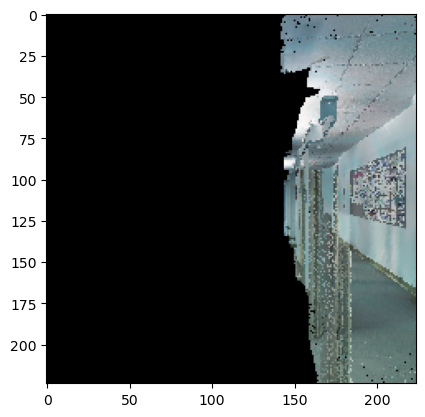

In [23]:
plt.imshow(image_rgb.reshape(224,224,3))

In [135]:
def transform_point(point, model_matrix, view_matrix, projection_matrix):
    
    world_coords = model_matrix @ point
    camera_coords = view_matrix @ world_coords
    clip_coords = projection_matrix @ camera_coords
    ndc_coords = clip_coords[:3] / clip_coords[3]  # Perspective division
    return ndc_coords
#     return clip_coords[:3]

In [12]:
# Define a 3D point in homogeneous coordinates
point = np.hstack((points_3d[:,1].reshape(-1, 1), points_3d[:,2].reshape(-1, 1), points_3d[:,0].reshape(-1, 1), np.ones((points_3d.shape[0], 1)), points_3d[:,3:]))  # (x, y, z, w)
new_coords = []


# Transform the point through the whole pipeline
for p in point:
    new_coords.append(np.hstack((transform_point(p[0:4], model_matrix, view_matrix, projection_matrix), p[4], p[5], p[6])))

# vis(np.array(new_coords)[:,0:3], np.array(new_coords)[:,3:6])

# Project to screen coordinates
screen_coords = project_to_screen(np.array(new_coords), width, height)

x_coords = screen_coords[:, 0].astype(np.int32)

y_coords = screen_coords[:, 1].astype(np.int32)
colors = screen_coords[:, 3:6].astype(np.uint8)  # Assuming RGB values in uint8 format

# Calculate the actual dimensions of the image
img_width = min(np.max(x_coords) + 1, width)
img_height = min(np.max(y_coords) + 1, height)

# Create a blank image with specified dimensions
image = np.zeros((img_height, img_width, 3), dtype=np.uint8)

# Assign colors to corresponding coordinates within the limits
valid_indices = (x_coords < img_width) & (y_coords < img_height) & (0 <= x_coords) & (0 <= y_coords)
image[y_coords[valid_indices], x_coords[valid_indices]] = colors[valid_indices]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2.imwrite('/media/xi/KINGSTON/New folder/image2.png', image_rgb)

# Visualize the point on a 2D screen
plt.figure(figsize=(20, 10))
plt.scatter(screen_coords[:, 0], screen_coords[:, 1], c=screen_coords[:, 3:6]/255, s=0.6)
plt.xlim(0, width)
plt.ylim(height, 0)  # Invert y-axis for screen coordinates
plt.title("Projected 3D Point on 2D Screen")
plt.xlabel("Screen X")
plt.ylabel("Screen Y")
plt.grid(True)
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [57]:
point[0][0:4]

array([-29.436,   1.403,   0.774,   1.   ])

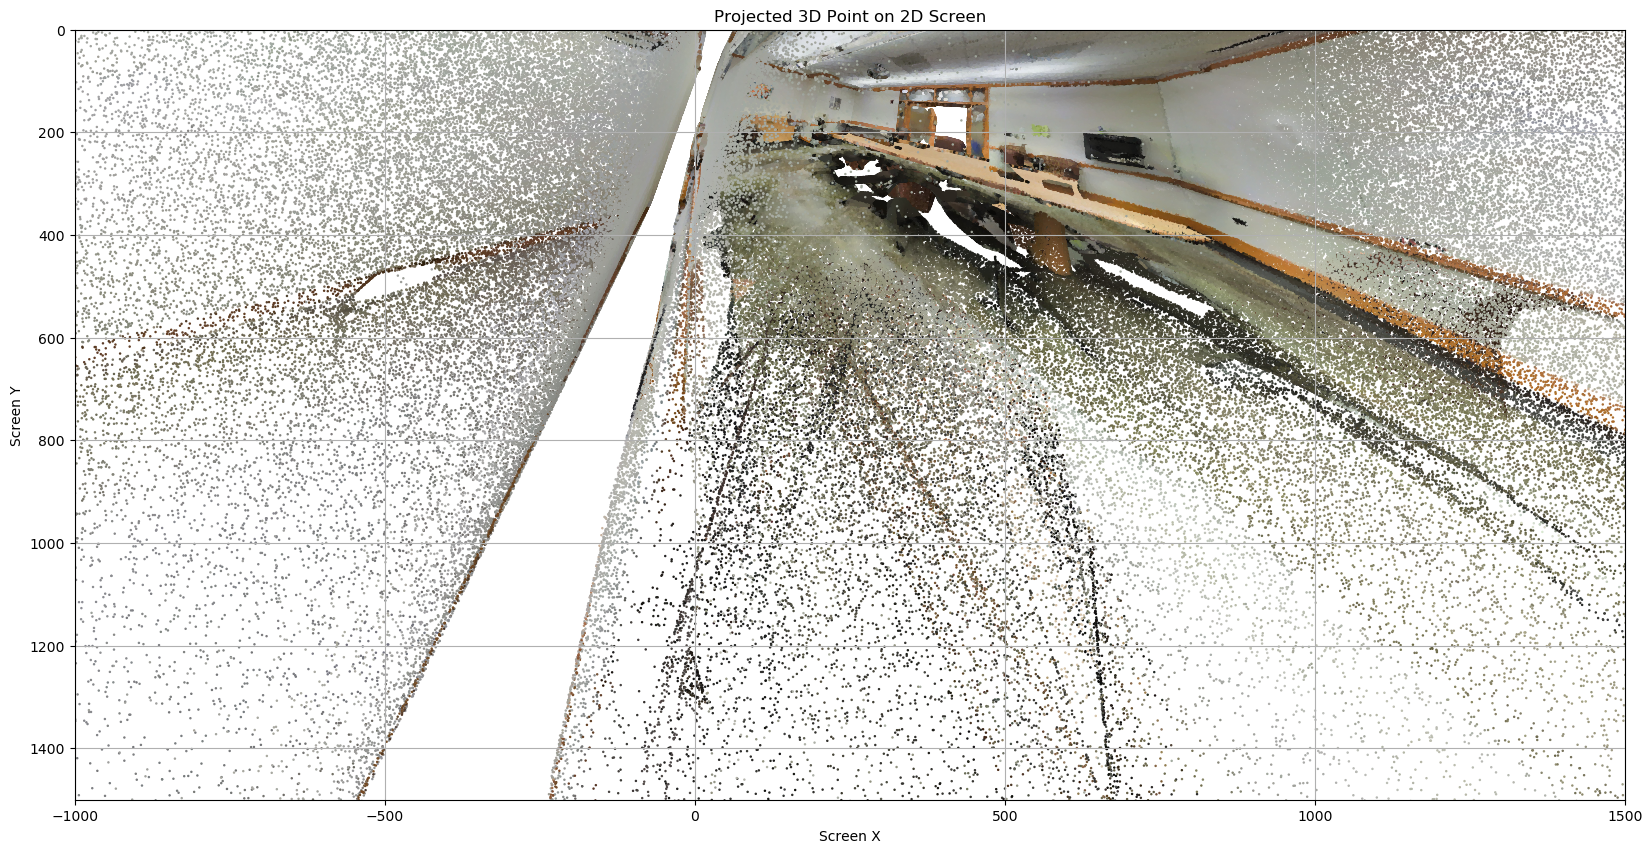

In [102]:
# Visualize the point on a 2D screen
plt.figure(figsize=(20, 10))
plt.scatter(screen_coords[:, 0], screen_coords[:, 1], c=screen_coords[:, 3:6]/255, s=0.6)
plt.xlim(-1000, 1500)
plt.ylim(1500, 0)  # Invert y-axis for screen coordinates
plt.title("Projected 3D Point on 2D Screen")
plt.xlabel("Screen X")
plt.ylabel("Screen Y")
plt.grid(True)
plt.show()

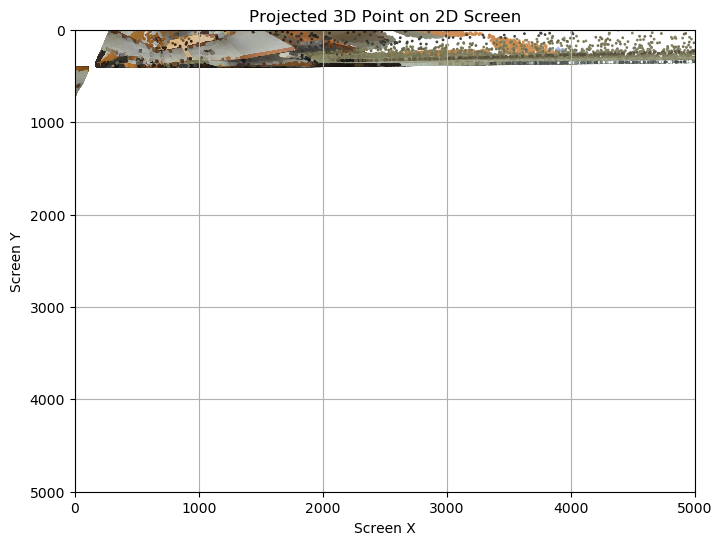

In [232]:
plt.figure(figsize=(8, 6))
plt.scatter(screen_coords[:, 0], screen_coords[:, 1], c=screen_coords[:, 3:6]/255, s=1)
plt.xlim(0, 5000)
plt.ylim(5000, 0)  # Invert y-axis for screen coordinates
plt.title("Projected 3D Point on 2D Screen")
plt.xlabel("Screen X")
plt.ylabel("Screen Y")
plt.grid(True)
plt.show()

In [6]:
width, height = 1000, 900
fov = np.pi / 20  # 60 degrees
near, far = 0.1, 1000.0
aspect_ratio = width / height
points_3d = np.loadtxt("H:/Stanford3dDataset_v1.2_Aligned_Version/Stanford3dDataset_v1.2_Aligned_Version/Area_4/conferenceRoom_3/conferenceRoom_3.txt")
# Define camera parameters
camera_position = np.array([np.mean(points_3d[:,0]), np.mean(points_3d[:,1]), np.mean(points_3d[:,2])])
target = np.array([-2, 1, 1])
up = np.array([0, 1, 0])

# Define model matrix (identity for simplicity)
model_matrix = np.identity(4)

# Compute view and projection matrices
view_matrix = look_at(camera_position, target, up)
projection_matrix = perspective_projection(fov, aspect_ratio, near, far)

FileNotFoundError: H:/Stanford3dDataset_v1.2_Aligned_Version/Stanford3dDataset_v1.2_Aligned_Version/Area_4/conferenceRoom_3/conferenceRoom_3.txt not found.

In [109]:
max(np.array(ndc_coords)[:,0])

557747.1521485946

In [217]:
vertices = np.loadtxt("H:/Stanford3dDataset_v1.2_Aligned_Version/Stanford3dDataset_v1.2_Aligned_Version/Area_4/conferenceRoom_3/Annotations/ceiling_1.txt")

In [218]:
vertice = np.zeros(vertices.shape)

vertice[:,0] = vertices[:,1]
vertice[:,1] = vertices[:,0]
vertice[:,2] = vertices[:,2]

In [93]:
screen_coords[:,:].shape

(1653935, 6)

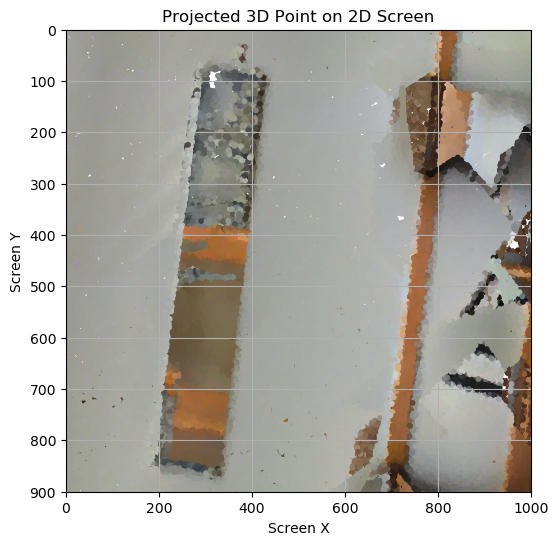

In [118]:
plt.figure(figsize=(6, 6))

plt.scatter(screen_coords[:, 0], screen_coords[:, 1], c=screen_coords[:, 3:6]/255, s=10)
plt.xlim(0, width)
plt.ylim(height, 0)  # Invert y-axis for screen coordinates
plt.title("Projected 3D Point on 2D Screen")
plt.xlabel("Screen X")
plt.ylabel("Screen Y")
plt.grid(True)
plt.show()

In [63]:
min(np.array(screen_coords)[0])

872

In [97]:
screen_coords[:,3:6].shape

(1653935, 3)

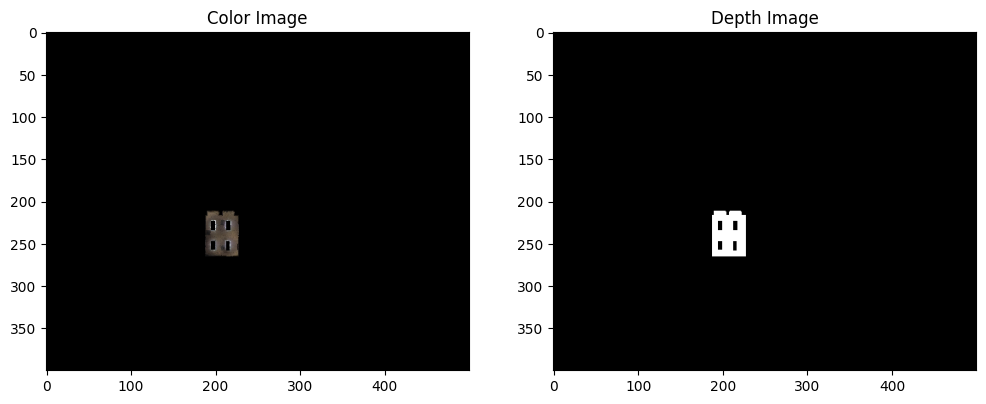

In [42]:
plt.figure(figsize=(12, 12))
 
plt.subplot(1, 2, 1)
plt.title("Color Image")
plt.imshow(color_image.astype('uint8'))
 
plt.subplot(1, 2, 2)
plt.title("Depth Image")
plt.imshow(depth_image.astype('uint8'), cmap='gray')
plt.show()